# Introduction


La classification des sons est l'une des applications les plus utilisées dans **Audio Deep Learning**. Cela implique d'apprendre à classer les sons et à prédire la catégorie de ce son. Ce type de problème peut être appliqué à de nombreux scénarios pratiques, par exemple la classification de clips musicaux pour identifier le genre de la musique, ou la classification de courts énoncés par un ensemble de locuteurs pour identifier le locuteur en fonction de la voix.

Tout comme la classification des chiffres écrits à la main à l'aide de l'ensemble de données MNIST considérée comme un problème de type "Hello World" pour introduire la vision par ordinateur, la classification audio est lui aussi considérée comme le problème d'introduction pour Audio Deep Learning.

Dans cet article, nous allons parcourir une application de démonstration simple afin de comprendre l'approche utilisée pour résoudre ces problèmes de classification audio. Mon objectif tout au long de ce tutoriel sera de te faire comprendre non seulement comment ces programmes fonctionnent, mais aussi, pourquoi ils fonctionnent de cette façon.

# Les données

Il existe de nombreux ensembles de données appropriés disponibles pour les sons de différents types. Ces ensembles de données contiennent un grand nombre d'échantillons audio, ainsi qu'une étiquette de classe pour chaque échantillon qui identifie le type de son dont il s'agit, en fonction du problème qu'on essaie de résoudre. Ces étiquettes de classe peuvent souvent être obtenues à partir d'une partie du nom de fichier de l'échantillon audio ou du nom du sous-dossier dans lequel se trouve le fichier. Alternativement, les étiquettes de classe sont spécifiées dans un fichier de métadonnées séparé, généralement au format TXT, JSON ou CSV.

Pour notre exemple de projet, nous allons utiliser l'ensemble de données [**Urban Sound 8K**](https://urbansounddataset.weebly.com/urbansound8k.html) qui consiste en un corpus de sons ordinaires enregistrés qu'on retrouve dans notre vie quotidienne en ville. Les sons sont rangés en 10 classes telles que le forage, les aboiements de chiens et les sirènes. Chaque échantillon sonore est étiqueté avec la classe à laquelle il appartient. Cette ensemble de donnée paise environ **5.6 GB**.

Après avoir téléchargé ce jeu de données, on remarque qu'il se compose de deux parties :

- Les **fichiers audio** dans le dossier `audio` qui comporte 10 sous-dossiers nommés de `fold1` à `fold10`. Dans chaque sous-dossier on trouve un certain nombre d'échantillons audio avec l'extension **.wav**, par exemple : `pli1/103074–7–1–0.wav`. Chaque échantillons durent environ 4 secondes.
- Les **métadonnées** dans le dossier `metadata` qui contient un fichier nommé `UrbanSound8K.csv` qui contient des informations sur chaque échantillon audio du jeu de données, telles que son nom de fichier, son étiquette de classe, l'emplacement du sous-dossier 'fold', etc. L'étiquette de classe est un entier qui vari de 0 à 9 pour chacune des 10 classes, par exemple : le chiffre 0 désigne climatiseur, 1 : un klaxon de voiture, etc.

Comme pour la plupart des problèmes de deep learning, nous suivrons les étapes présentées dans la figure suivante :

![Flux de travail d'apprentissage en profondeur](images/dl_steps.png)

Pour notre tâche de classification, les caractéritiques $X$ désigneront les chemins vers des fichiers audio et les étiquettes cibles $y$ vont désignés les noms de classe.

## Récupération des données

Pour télécharger l'ensemble de données, on va juste exécuter la commande suivante :
```sh
wget -c https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
```
Voici le code à exécuter dans un noteboock :

In [1]:
!wget -c https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

--2023-08-05 10:09:17--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  18.0MB/s    in 6m 30s  

2023-08-05 10:15:49 (14.7 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



Une fois le téléchargement terminé, il faut décompresser le fichier en exécutant la commande suivante :

In [15]:
!tar -xzf UrbanSound8K.tar.gz

## Préparation des données d'entraînement

De nombreux ensembles de données se composent uniquement de fichiers audio organisés dans une structure de dossiers à partir de laquelle on peut extraire les étiquettes de classe. Pour préparer nos données d'entraînement dans le format necessaire pour notre modèle, nous procédera en trois (03) étapes :

- Analyser le répertoire pour préparez une liste de tous les chemins de fichiers audio;
- Extraire l'étiquette de classe de chaque fichier audio du nom de son dossier parent;
- Faire correspondre chaque nom de classe à un numéro unique.

Étant donné que l'ensemble de données contient déjà un fichier CSV de métadonnées contenant les informations recherchées sur chaque fichier audio, on va l'utiliser directement.

In [5]:
import pandas as pd


# On ouvre et on affiche les 5 premiers lignes du fichier.
metadata_df = pd.read_csv("./UrbanSound8K/metadata/UrbanSound8K.csv")
metadata_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


On a besoin d'une créer une colonnes de plus pour préparer les données à d'entraînement. Il s'agit de la colonne qui contiendra le chemin d'accès vers chaque fichier audio. Pour cela, on va ajouter une nouvelle colonne nommée `'relative_path'` qui représentera le chemin relatif vers chaque fichier audio.

In [8]:
# On construit le chemin relatif vers chaque fichier audio.
metadata_df['relative_path'] = './UrbanSound8K/audio/fold' \
        + metadata_df['fold'].astype(str) \
        + '/' \
        + metadata_df['slice_file_name'].astype(str) \

# On affiche un apperçu.
metadata_df[['relative_path']].head()

,relative_path
0,./UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,./UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,./UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,./UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,./UrbanSound8K/audio/fold5/100263-2-0-137.wav


On a juste besoin de deux colonnes dans cette table de données pour constituer la dataset d'entraînement, donc récupérons les dans une nouvelle variable.

In [9]:
# On sélectionne donc les colonnes 'relative_path' et `'classID'`
dataset_df = metadata_df[['relative_path', 'classID']]
dataset_df.head()

,relative_path,classID
0,./UrbanSound8K/audio/fold5/100032-3-0-0.wav,3
1,./UrbanSound8K/audio/fold5/100263-2-0-117.wav,2
2,./UrbanSound8K/audio/fold5/100263-2-0-121.wav,2
3,./UrbanSound8K/audio/fold5/100263-2-0-126.wav,2
4,./UrbanSound8K/audio/fold5/100263-2-0-137.wav,2


Le faite d'avoir le chemin d'accès vers les fichiers audio va nous faciliter les choses pour préparation des données d'apprentissage.

En effet, on ne peut pas faire entrer des chemins de fichiers audio directement dans le modèle. Nous devons donc lire et charger les données audio de chaque fichier et les traiter afin qu'elles soient dans un format exploitable par le modèle.

Ce prétraitement audio sera entièrement effectué dynamiquement au moment de l'exécution de programme d'entraînement. Cette approche est similaire à celle des fichiers images en vision par ordinateur. Car, comme les données d'image, les données audio sont assez volumineuses et gourmandes en mémoire, ce qui fait qu'on ne peut pas charger l'intégralité de l'ensemble de données en mémoire à l'avance. Donc, les seules informations qu'on arriver à conserver en mémoire sont les chemins d'accès vers ces fichiers audio (ou image).

Les données audio sont traitées en appliquant une série de transformations. Exactement comme pour les images, nous pourrions un pipeline de transformations constitué d'une liste de fonctions de traitement audio.

Voici la liste des fonctions à programmer :

1. Lecture de fichier audio;
2. Conversion en 2 canaux (stereo);
3. Normalisation du taux d'échantillonnage;
4. Redimensionnement à la même longueur (durée);
5. Décalage temporel pour l'augmentation;
6. Génération de Spectrogramme Mel;
7. Masquage temporel et fréquentiel pour l'augmentation.


### Lecture de fichier audio

La première chose dont nous avons besoin est de lire et de charger le fichier audio au format **.wav**. Puisque nous utilisons [**Pytorch**](https://pytorch.org/) pour cet exemple, l'implémentation ci-dessous utilise `torchaudio` pour le traitement audio, mais le package python `librosa` peut aussi faire l'affaire.

In [11]:
from typing import Tuple
import torch
import torchaudio
from torchaudio import transforms


def read(audio_file: str) -> Tuple[torch.Tensor, int]:
    """ Fonction de lecture des données audio.

    On utilise la fonction `load()` de `torchaudio`.
    Pour plus d'information, voici un lien :
    https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html#loading-audio-data

    Arguments:
        audio_file (`str`): Le chemin d'accès vers le fichier audio.

    Returns:
        `tuple`: constitué d'un tenseur et d'un entier.
           * Le tenseur nommé `waveform` représente les données audio;
           * et l'entier nommé `sample_rate` représente le taux
             d'échantillonnage.

    Example:
        >>> waveform, sample_rate = read('./pathto/audio_file.wav')
        >>> print(sample_rate)
        44100
    """
    waveform, sample_rate = torchaudio.load(audio_file)
    return (waveform, sample_rate)

Pour tester, on va essayer de lire un des audios de notre ensemble de donnée et d'afficher ses dimensions et son taux (fréquence) d'échantillonnage.

In [14]:
audio_file_name = dataset_df['relative_path'][0]
audio = read(audio_file_name)
signal, sample_rate = audio
print(f"* Nom du fichier de l'audio : {audio_file_name}")
print(f"* Les dimensions du signal : {signal.shape}")
print(f"* Taux d'échantillonnages : {sample_rate}")

* Nom du fichier de l'audio : ./UrbanSound8K/audio/fold5/100032-3-0-0.wav
* Les dimensions du signal : torch.Size([2, 14004])
* Taux d'échantillonnages : 44100


Ce fichier audio qu'on vient de lire par exemple est sur deux canaux car le tenseur du signal comporte 2 lignes.

### Conversion en 2 canaux (stereo)

Dans un ensemble de données de fichiers audio, il peut arriver qu'on ait certains fichiers son sont **mono** (c'est-à-dire 1 canal audio) tandis que la plupart d'entre eux soient **stéréo** (c'est-à-dire 2 canaux audio). Étant donné que notre modèle s'attend à ce que tous les données d'entrées aient les mêmes dimensions, alors nous sommes amenés à convertir les fichiers audio mono en stéréo, en dupliquant juste le premier canal sur le second.

In [ ]:
from typing import Tuple
import torch


def rechannel(audio: Tuple[torch.Tensor, int],
              channel_count: int) -> Tuple[torch.Tensor, int]:
    """ Fonction de conversion de canal.

    La conversion de mono en stéréo revient juste
    à concatener une copie du tableau de données
    audio (waveform) à lui-même.

    Arguments:
        audio (:obj:`tuple`): Le tuple waveform et sample_rate.
        channel_count (`int`): Le nombre de cannaux souhaités.

    Returns:
        `tuple`: Le couple formé du tenseur modifié
                 et du taux d'échantillonnage.

    Example:
        >>> audio = read('./pathto/audio_file.wav')
        >>> audio_mono = rechannel(audio, 1)  # converti en mono.
        >>> audio_stereo = rechannel(audio, 2)  # converti en stéréo.
        >>>
    """
    if channel_count not in (1, 2):
        raise ValueError("Le nombre de channal doit être 1 ou 2.")

    wave_form, sample_rate = audio
    # NOTE: Le nombre de cannal est égal
    #       au nombre de lignes du tableau wave_form.
    if wave_form.shape[0] == channel_count:
        # Plus la peine de continuer si le nombre de cannaux de ce audio
        # est déjà le nombre de cannal souhaité.
        return audio

    wave_form_rech = None
    if channel_count == 2:
        # on convertie en stéréo:
        wave_form_rech = torch.cat([wave_form, wave_form])
    elif channel_count == 1:
        # on convertie en mono:
        wave_form_rech = wave_form[:1, :]

    return (wave_form_rech, sample_rate)


### Normalisation du taux d'échantillonnage

Toujours dans cette même ensemble de données, certains fichiers audio sont échantionnés à une fréquence de 48000 Hz, alors que la plupart sont échantillonnés à une fréquence de 44100 Hz.

Pour rappel, en mécanique, la fréquence est le nombre de tours enrégistrés en une seconde et un tour correspond une période du signal. En traitement numérique du signal, les signaux audio sont généralement échantillonnés à une fréquence de **44100 Hz**, ce qui signifie les données audio récupérées en une seconde sont stockées dans un **tableau de taille 44100**.

Donc, pour certains fichiers audio de notre dataset, une seconde d'audio aura une taille de tableau de 48 000, or qu'elle devrait avoir une taille de tableau plus petite, 44 100 comme la majorité. Ce sont ces raisons qui nous amène à vouloir normaliser en convertissant tout l'audio au même taux d'échantillonnage afin que tous les tableaux aient les mêmes dimensions.

In [ ]:
from typing import Tuple
import torch
from torchaudio import transforms as T


def resample(audio: Tuple[torch.Tensor, int],
             new_sample_rate: int) -> Tuple[torch.Tensor, int]:
    """ Fonction de normalisation de la fréquence d'échantionnage.

    On va utiliser la classe `Resample` du module `transforms`
    du package `torchaudio` pour effectuer cette normalisation.

    Arguments:
        audio (:obj:`tuple`): Le tuple waveform et sample_rate.
        new_sample_rate (`int`): La nouvelle fréquence d'échantillonnage
                                 vers laquelle on veut convertir les données
                                 audio.

    Returns:
        `tuple`: Le couple formé du tenseur modifié
                 et du nouveau taux d'échantillonnage.

    Example:
        >>> audio = read('./pathto/audio_file.wav')
        >>> audio = resample(audio, 44100)
        >>>
    """
    wave_form, sample_rate = audio
    if sample_rate == new_sample_rate:
        # Il n'y plus rien à faire d'autre.
        return audio

    resample_obj = T.Resample(sample_rate, new_sample_rate)
    wave_form_resample = resample_obj(wave_form[:1, :])

    num_channels = wave_form.shape[0]
    if num_channels > 1:
        # S'il y a un second canal.
        wf_second_channel = resample_obj(wave_form[1:, :])
        wave_form_resample = torch.cat([wave_form_resample, wf_second_channel])

    return (wave_form_resample, new_sample_rate)


### Redimensionnement à la même longueur (durée)

On doit modifier ensuite tous les échantillons audio pour qu'ils aient la même longueur, c'est-à-dire la même durée. Pour faire cela, soit on prolonge la durée de ces audios en **les remplissant de silence** (en anglais, on parle de **padding**), soit, on les tronque. Cela dépendra de la longueur maximale fixée, de la longueur de l'audio. On cherche tout simplement à s'assurer que toutes les données audio de l'ensemble de données ont la même longueur.

In [17]:
import random
from typing import Tuple

import torch


def reshape_len(audio: Tuple[torch.Tensor, int],
                max_duration: int) -> Tuple[torch.Tensor, int]:
    """ Fonction de redimensionnement de la longeur des audios.

    Si la longueur (durée) maximale fixée `max_duration` est inférieur à la longeur
    de l'audio, alors l'audio sera tronqué, sinon on prolongera sa durée en rajoutant
    une série de `0` jusqu'à la longueur maximale.

    Arguments:
        audio (:obj:`tuple`): Le tuple waveform et sample_rate.
        max_duration (`int`): La durée maximale fixée en milliseconde.

    Returns:
        `tuple`: Le couple formé du tenseur modifié et qui désormais
                 les mêmes tailles et du taux d'échantillonnage.

    Example:
        >>> audio = read('./pathto/audio_file.wav')
        >>> audio = reshape_len(audio, 15000)  # ici la longueur est fixée à 15 sec.
        >>> print(audio[0].shape)
        torch.Size([2, 660000])
    """
    signal, sample_rate = audio
    n_rows, signal_len = signal.shape
    # `n_rows`: représente le nombre de canal, donc vaux 2 et
    # `signal_len`: la longueur du signal qui vaut 44100 * durée (en seconde).

    # Il nous faut calculer la taux d'échantillonnage pour 1 milliseconde
    # sachant que le taux d'échantillonnage pour 1 seconde est 44100.
    #       1  ---->  ?
    #    1000  ---->  44100 = `sample_rate`
    # Par la règle de 3, on retrouve `sample_rate` / 1000, mais on fera une division
    # entière histoire de ne pas avoir un nombre à virgule. Ce qui nous donne 44.
    millis_sample_rate = sample_rate // 1000
    # Maintenant, on va pouvoir calculer la longueur de séquence
    # correspondante à la durée `max_duration` fixée en milliseconde.
    max_len = millis_sample_rate * max_duration  # 44 * `max_duration`

    if max_len == signal_len:
        # alors c'est génial, rien à faire.
        return audio

    if signal_len < max_len:
        # alors on fera un padding,
        # il faut donc calculer la longueur de la marge total à rajouter.
        pad_len = max_len - signal_len

        # Maintenant, qu'on connais combien de marge total il faut rajouter
        # alors on va calculer combien de marge il faut ajouter au début
        # et combien il faut rajouter à la fin. Pour cela on va prendre un
        # nombre entre 0 et pad_len de façon aléatoire qui va représenter la
        # marge de début et le soustraire de pad_len pour calculer la marge de fin.
        begin_pad_len = random.randint(0, pad_len)
        end_pad_len = pad_len - begin_pad_len

        # on initialise deux matrices nules chacune de taille
        #  - `n_rows` X `begin_pad_len`
        #  - `n_rows` X `end_pad_len`
        # respectivement pour la marge de début et de fin.
        # Voici à quoi resemble chacune des deux matrices :
        # [[0, 0, ... 0],  ---> canal 1
        #  [0, 0, ... 0]]  ---> canal 2
        begin_pad = torch.zeros((n_rows, begin_pad_len))
        end_pad = torch.zeros((n_rows, end_pad_len))

        # On peut ajouter maintenant ces deux marges au signe d'origine.
        # Exemple: Si la longueur total de la marge à faire faisait : 10.
        #          En supposant que le choix aléatoire de la longeur de
        #          début a donnée 4, alors on aura 6 comme longueur de
        #          fin et qui donne l'exemple de résultat suivant :
        # [[0, 0, 0, 0, 12, 208, ... 79,  9, 0, 0, 0, 0, 0, 0],  ---> canal 1
        #  [0, 0, 0, 0, 90,   3, ...  5, 28, 0, 0, 0, 0, 0, 0]]  ---> canal 2
        signal = torch.cat((begin_pad, signal, end_pad), 1)
    else:
        # alors on fera une trocature, car la longueur du signal
        # d'origine dépasse la longueur maximale fixée.
        signal = signal[:, :max_len]

    return (signal, sample_rate)

Dans le cas où la longueur du signal est inférieur à la longueur maximale fixée, on préfère partager les marges au début et à la fin du signal de façon aléatoire et non de façon équitable, parce qu'on ne voudrait pas que notre modèle se mette à généraliser sur certaines constantes.

Faisons un petit teste sur un des audios afin de mieux comprendre.

In [19]:
audio_file_name = dataset_df['relative_path'][0]
audio = read(audio_file_name)
signal, sample_rate = audio
print(f"* Nom du fichier de l'audio : {audio_file_name}")
print(f"* Les dimensions du signal : {signal.shape}")
print(f"* Taux d'échantillonnages : {sample_rate}")

print("--------------------------------------------------")

# Maintenant, on va faire fixée une durée
# maximale de 2 secondes pour notre audio.
audio = reshape_len(audio, 2000)
signal, sample_rate = audio
print(f"* Nom du fichier de l'audio : {audio_file_name}")
print(f"* Les dimensions du signal : {signal.shape}")
print(f"* Taux d'échantillonnages : {sample_rate}")

* Nom du fichier de l'audio : ./UrbanSound8K/audio/fold5/100032-3-0-0.wav
* Les dimensions du signal : torch.Size([2, 14004])
* Taux d'échantillonnages : 44100
--------------------------------------------------
* Nom du fichier de l'audio : ./UrbanSound8K/audio/fold5/100032-3-0-0.wav
* Les dimensions du signal : torch.Size([2, 88000])
* Taux d'échantillonnages : 44100


Logique, car la longueur necessaire à 2 secondes de son est calculée par la formule suivante :

$$
v = \frac{d}{t} => d = v \times t
$$

Avec $d$ la taille en mémoire, $v$ la fréquence d'échantillonnage et $t$ la durée du son. C'est donc exactement comme en mécanique, où :

$$
vitesse = \frac{distance}{temps}
$$

En remplaçant donc les variables par leur valeur, on a
$v = 44$, $t = 2000$ et donc $d = 44 \times 2000 = 88000$.


### Décalage temporel

Nous pouvons augmenter les données, c'est à dire générer d'autres sons en plus à partir de ceux de l'ensemble de données en faisait des décalages temporel. Ce dernier consiste décaler l'audio vers la gauche ou la droite d'un nombre aléatoire de positions.

In [82]:
import logging
import random
from typing import Tuple

import torch


LOG = logging.getLogger(__name__)  # c'est juste pour afficher un message.


def shift(audio: Tuple[torch.Tensor, int],
                shift_limit: int) -> Tuple[torch.Tensor, int]:
    """ Fonction de fonctions de décalage d'un  signal audios.

    Arguments:
        audio (:obj:`tuple`): Le tuple waveform et sample_rate.
        shift_limit (`int`): Le nombre maximal de position.

    Returns:
        `tuple`: Le couple formé du tenseur modifié qui contient
                 le signal décalé et du taux d'échantillonnage.
    """
    signal, sample_rate = audio
    _, signal_len = signal.shape

    shift_places = int(random.random() * shift_limit)
    shift_signal = torch.roll(signal, shift_places, 1)
    LOG.warning("Décalage de " + str(shift_places))

    return (shift_signal, sample_rate)

La fonction `torch.roll()` permet de décaler les éléments d'un tenseur. Les détails se trouvent à ce [lien](https://pytorch.org/docs/stable/generated/torch.roll.html).

Testons cela avec un exemple qu'on va visualiser.

In [90]:
audio_file_name = dataset_df['relative_path'][100]
audio = read(audio_file_name)
shift_audio = shift(audio, 100)

On va maintenant écrire une fonction qui va nous permettre de visualiser le signal sur un graphique.

In [94]:
import numpy as np
import matplotlib.pyplot as plt


def plot_signal(s1, s2, max_time=1000, dt=1):
  """ Fonction de représentation graphique
      de deux signals sur une même figure.
  """
  t = np.arange(0, max_time, dt)
  s1 = s1[:t.shape[0]]
  s2 = s2[:t.shape[0]]

  fig, ax = plt.subplots()
  ax.plot(t, s1, label='original')
  ax.plot(t, s2, label='modified')
  ax.set_xlabel("Time")
  ax.set_ylabel("signal s1, s2")

  plt.grid(True)
  plt.legend()
  plt.show()


On va simplement représente un seul canal de ces deux signaux.

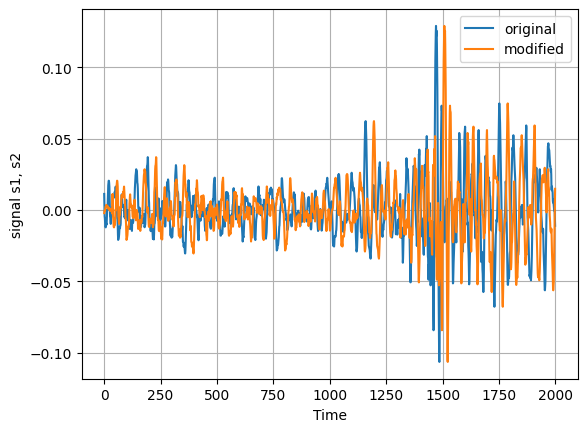

In [95]:
original_signal = audio[0][0]
shift_signal = shift_audio[0][0]

plot_signal(original_signal, shift_signal, 2000)